# 🫀 Winter Project — Disease Risk Predictor 


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,
ConfusionMatrixDisplay,roc_curve,auc,classification_report)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Reproducibility

In [2]:
SEED = 100

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Loading and exploring dataset

In [3]:
data_set = pd.read_table("processed.cleveland.data",sep=",",names=['age','sex','cp','trestbps','chol','fbs'
,'restecg','thalach','exang','oldpeak','slope','ca','thal','num'])

print("First 5 rows:",data_set.head())
print("Dataset shape:",data_set.shape)
print("Dataset Information:",data_set.info())



First 5 rows:     age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  num  
0    3.0  0.0  6.0  0.0  
1    2.0  3.0  3.0  2.0  
2    2.0  2.0  7.0  1.0  
3    3.0  0.0  3.0  0.0  
4    1.0  0.0  3.0  0.0  
Dataset shape: (318, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       318 non-null    float64
 1   sex       318 non-null    float64
 2   cp        318 non-null    float64
 3   trestbps  318 non-null    float64
 4 

#### Since ca and thal has dtype object,we have to handle non numeric values like "?" in these columns

# Handling non numeric values in ca and thal columns

#### Finding non numeric values in these two columns

In [4]:
print("Unique values in thal column:",data_set['thal'].unique())
print("Unique values in ca column:",data_set['ca'].unique())

Unique values in thal column: ['6.0' '3.0' '7.0' '?']
Unique values in ca column: ['0.0' '3.0' '2.0' '1.0' '?']


#### Turning them into Nan

In [5]:
data_set.replace(to_replace='?',value=np.nan,inplace=True)
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       318 non-null    float64
 1   sex       318 non-null    float64
 2   cp        318 non-null    float64
 3   trestbps  318 non-null    float64
 4   chol      318 non-null    float64
 5   fbs       318 non-null    float64
 6   restecg   318 non-null    float64
 7   thalach   318 non-null    float64
 8   exang     318 non-null    float64
 9   oldpeak   318 non-null    float64
 10  slope     318 non-null    float64
 11  ca        299 non-null    object 
 12  thal      305 non-null    object 
 13  num       318 non-null    float64
dtypes: float64(12), object(2)
memory usage: 34.9+ KB


#### Now we can see there are null values which we will handle in next section

# Preprocessing

#### Splitting dataset into features and target

In [6]:
X = data_set.drop(columns=['num'])
y = data_set['num']

#### Turning the target column into binary (0 or 1)

In [7]:
y_binary = (y > 0).astype(int)
print("Unique values in y:",y_binary.unique())

Unique values in y: [0 1]


#### Class counts

In [8]:
counts = np.bincount(y_binary)
print(f"Class 0:{counts[0]}")
print(f"Class 1:{counts[1]}")

Class 0:179
Class 1:139


#### Handling Nan values

In [9]:
mode_ca = X['ca'].mode()[0]
X.fillna({'ca':mode_ca},inplace=True)

mode_thal = X['thal'].mode()[0]
X.fillna({'thal':mode_thal},inplace=True)

X = X.astype({'ca':'float64','thal':'float64'})

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       318 non-null    float64
 1   sex       318 non-null    float64
 2   cp        318 non-null    float64
 3   trestbps  318 non-null    float64
 4   chol      318 non-null    float64
 5   fbs       318 non-null    float64
 6   restecg   318 non-null    float64
 7   thalach   318 non-null    float64
 8   exang     318 non-null    float64
 9   oldpeak   318 non-null    float64
 10  slope     318 non-null    float64
 11  ca        318 non-null    float64
 12  thal      318 non-null    float64
dtypes: float64(13)
memory usage: 32.4 KB


#### Train / Validation / Test Split

In [10]:
x_train,x_temp,y_train,y_temp = train_test_split(X,y_binary,train_size=0.7,stratify=y_binary,random_state=100)
x_validation,x_test,y_validation,y_test = train_test_split(x_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=100)

print("Training set size:")
print(f"x_train:{x_train.shape}")
print(f"y_train:{y_train.shape}")

print("Validation set size:")
print(f"x_validation{x_validation.shape}:")
print(f"y_validation:{y_validation.shape}")

print("Test set size:")
print(f"x_test:{x_test.shape}")
print(f"y_test:{y_test.shape}")

Training set size:
x_train:(222, 13)
y_train:(222,)
Validation set size:
x_validation(48, 13):
y_validation:(48,)
Test set size:
x_test:(48, 13)
y_test:(48,)


#### Z-Score Normalization

In [11]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_validation_scaled = scaler.transform(x_validation)
x_test_scaled = scaler.transform(x_test)

print(f"x_train_scaled mean:{x_train_scaled.mean(axis=0)}")
print(f"x_validation_scaled mean:{x_validation_scaled.mean(axis=0)}")
print(f"x_test_scaled mean:{x_test_scaled.mean(axis=0)}")

print(f"x_train_scaled std:{x_train_scaled.std(axis=0)}")
print(f"x_validation_scaled std:{x_validation_scaled.std(axis=0)}")
print(f"x_test_scaled std:{x_test_scaled.std(axis=0)}")


x_train_scaled mean:[-1.22024513e-16  2.40048222e-17 -1.29526020e-16  2.20044203e-16
 -2.08291842e-16 -2.40048222e-17 -8.00160738e-17  3.96079566e-16
 -4.00080369e-17 -7.40148683e-17 -1.28025718e-16 -4.60092425e-17
 -1.36027326e-16]
x_validation_scaled mean:[ 0.1085793  -0.42347068 -0.22855327 -0.03361313  0.02326463  0.18275239
  0.09515708 -0.17405453  0.34099779 -0.1758745  -0.16015965  0.05780553
 -0.07700407]
x_test_scaled mean:[-0.23135742 -0.14200214  0.00124214 -0.10718997 -0.07150441  0.12343802
 -0.03133916  0.09679563  0.1140748  -0.18098498 -0.06247986 -0.20408892
 -0.03399802]
x_train_scaled std:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
x_validation_scaled std:[1.09270661 1.12195805 1.25359658 0.96745821 0.93655347 1.15625
 0.97779221 1.04239832 1.0854417  0.74621699 0.84153401 0.95530664
 0.96494445]
x_test_scaled std:[1.08966928 1.06148432 1.00586359 1.04070415 0.72565672 1.11125443
 0.99937367 1.01664536 1.04187063 0.75965818 0.9431145  0.76975981
 1.00760655]


# Baseline Model (Decision Tree)

#### Training the model

In [12]:
baseline_tree = DecisionTreeClassifier(max_depth=5)
baseline_tree.fit(x_train_scaled,y_train)

DecisionTreeClassifier(max_depth=5)

# Main Model (Neural Networks) + Hyperparameter tuning

#### Dataset Loaders

In [13]:
g = torch.Generator()
g.manual_seed(SEED)

train_dataset = TensorDataset(torch.tensor(x_train_scaled,dtype=torch.float),
torch.tensor(y_train.values,dtype=torch.long))

validation_dataset = TensorDataset(torch.tensor(x_validation_scaled,dtype=torch.float),
torch.tensor(y_validation.values,dtype=torch.long))

test_dataset = TensorDataset(torch.tensor(x_test_scaled,dtype=torch.float),
torch.tensor(y_test.values,dtype=torch.long))

train_set_loader = DataLoader(train_dataset,batch_size=16,shuffle=True,generator=g)
validation_set_loader = DataLoader(validation_dataset,batch_size=16,shuffle=False)
test_set_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)

#### Neural Network Class

In [14]:
class NN(nn.Module):
    def __init__(self,dimension):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden_layer_1 = nn.Linear(dimension,32)
        self.dropout1 = nn.Dropout(0.4)
        self.hidden_layer_2 = nn.Linear(32,16)
        self.dropout2 = nn.Dropout(0.4)
        self.output_layer = nn.Linear(16,2)
        self.relu = nn.ReLU() 

    def forward(self,x):
        x = self.flatten(x)

        #Layer 1
        x = self.hidden_layer_1(x)
        x= self.relu(x)
        x = self.dropout1(x)

        #Layer 2
        x = self.hidden_layer_2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        #output layer
        x = self.output_layer(x) 
        return x

NN_model = NN(x_train_scaled.shape[1])

#### Hyperparameters

In [15]:
EPOCHS = 7
LR = 0.002
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN_model.parameters(),lr=LR)

#### Training Function

In [16]:
def train(model,dataloader,optimizer,criterion):
    model.train()  #put model in training mode 

    total_loss = 0.0       #sum of loss over all batches
    total_correct = 0      #correct no of predictions
    total_samples = 0      #total no of examples

    for features,labels in dataloader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(features) 
        loss = criterion(logits,labels) 
        optimizer.zero_grad() #clear previously accumulated gradients
        loss.backward() #compute gradients
        optimizer.step() # will update weights and bias using gradients calculated before

        batch_samples = labels.size(0) 
        total_loss += (batch_samples * loss.item()) #sum of losses of all samples in this batch

        predictions = logits.argmax(dim=1) #will give index of max logit along a row which means max logit along one example
        indexes = (predictions == labels) #mark the indexes with t or f
        total_correct += indexes.sum().item() # will count no of samples where predictions were correct
        total_samples += batch_samples #add current batch samples to total samples

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss,accuracy

#### Evaluation Function

In [17]:
def evaluate(model,dataloader,criterion):
    model.eval()  #put model in evaluation mode 

    total_loss = 0.0      
    total_correct = 0     
    total_samples = 0     

    with torch.no_grad(): #will block gradient calculations thus saving time and resources
        for features,labels in dataloader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(features) 
            loss = criterion(logits,labels) 
           
            batch_samples = labels.size(0) 
            total_loss += batch_samples * loss.item() 

            predictions = logits.argmax(dim=1) 
            indexes = (predictions == labels) 
            total_correct += indexes.sum().item() 
            total_samples += batch_samples

    average_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return average_loss,accuracy

#### Training Loop

In [18]:
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

best_accuracy = 0.0

for x in range(1,EPOCHS + 1):

    #training loss and accuracy
    train_loss,train_accuracy = train(NN_model,train_set_loader,optimizer,criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    #validation loss and accuracy
    validation_loss, validation_accuracy = evaluate(NN_model,validation_set_loader,criterion)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch [{x}/{EPOCHS}]")
    print(f"Training loss:{train_loss} | Training Accuracy:{train_accuracy}")
    print(f"Validation loss:{validation_loss} | Validation Accuracy:{validation_accuracy}")

    if (validation_accuracy > best_accuracy):
        best_accuracy = validation_accuracy
        torch.save(NN_model.state_dict(),"saved_model.pth") # saving the best model based on accuracy


Epoch [1/7]
Training loss:0.6937186240075944 | Training Accuracy:0.4864864864864865
Validation loss:0.6627262036005656 | Validation Accuracy:0.6875
Epoch [2/7]
Training loss:0.650344121563542 | Training Accuracy:0.6846846846846847
Validation loss:0.6244026223818461 | Validation Accuracy:0.8333333333333334
Epoch [3/7]
Training loss:0.6166634462975167 | Training Accuracy:0.7567567567567568
Validation loss:0.5787042578061422 | Validation Accuracy:0.7916666666666666
Epoch [4/7]
Training loss:0.554355849016894 | Training Accuracy:0.7612612612612613
Validation loss:0.5286756952603658 | Validation Accuracy:0.8125
Epoch [5/7]
Training loss:0.49845778942108154 | Training Accuracy:0.7792792792792793
Validation loss:0.497206707795461 | Validation Accuracy:0.8125
Epoch [6/7]
Training loss:0.45951542499903086 | Training Accuracy:0.8198198198198198
Validation loss:0.4870886007944743 | Validation Accuracy:0.8125
Epoch [7/7]
Training loss:0.44175492468717936 | Training Accuracy:0.8108108108108109
Vali

#### Plotting loss and accuracy curves

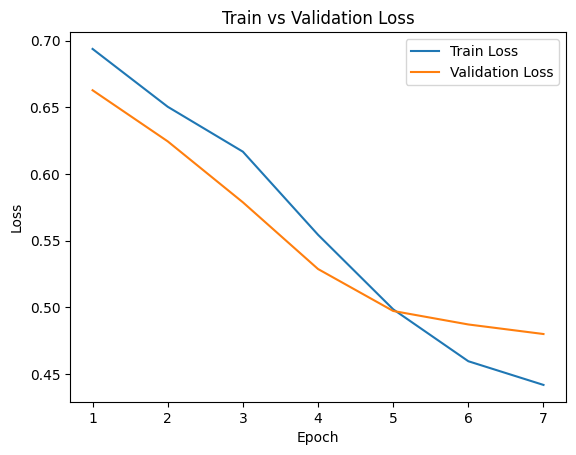

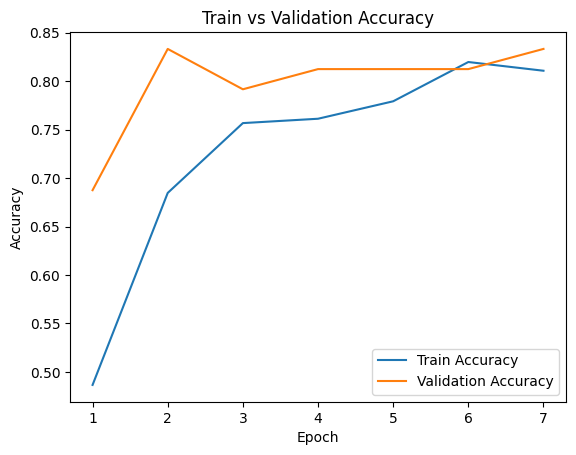

In [19]:
x_axis_range=range(1,EPOCHS + 1)
plt.plot(x_axis_range,train_losses,label="Train Loss")
plt.plot(x_axis_range,validation_losses,label="Validation Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plot accuracy curves
plt.plot(x_axis_range,train_accuracies,label="Train Accuracy")
plt.plot(x_axis_range,validation_accuracies,label="Validation Accuracy")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Loading the best model

In [20]:
chosen_model = NN(x_train_scaled.shape[1]).to(DEVICE)
chosen_model.load_state_dict(torch.load("saved_model.pth",map_location=DEVICE))
chosen_model.to(DEVICE)
chosen_model.eval()

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer_1): Linear(in_features=13, out_features=32, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (hidden_layer_2): Linear(in_features=32, out_features=16, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
)

# Evaluation on Test set

#### Baseline model evaluation

In [21]:
y_baseline = baseline_tree.predict(x_test_scaled)
accuracy = accuracy_score(y_test,y_baseline)
precision = precision_score(y_test,y_baseline)
recall = recall_score(y_test,y_baseline)
f1 = f1_score(y_test,y_baseline)

print("Baseline Tree evaluation on test set:")
print(f"Accuracy:{accuracy}")
print(f"Precision:{precision}")
print(f"Recall:{recall}")
print(f"F1 Score:{f1}\n")

print("Test Classification Report:")
print(classification_report(y_test,y_baseline))

Baseline Tree evaluation on test set:
Accuracy:0.7708333333333334
Precision:0.8125
Recall:0.6190476190476191
F1 Score:0.7027027027027026

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        27
           1       0.81      0.62      0.70        21

    accuracy                           0.77        48
   macro avg       0.78      0.75      0.76        48
weighted avg       0.78      0.77      0.77        48



#### Main model evaluation

In [22]:
all_labels = []   #label tensors 
all_predictions = []    # prediction tensors 
all_probabilities = [] #final probabilities

with torch.no_grad():  #since it is testing
    for features,labels in test_set_loader:
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = chosen_model(features)           
        predictions = logits.argmax(dim=1)
        probs = torch.softmax(logits,dim=1)
        probs = probs.cpu()
        labels = labels.cpu()
        predictions = predictions.cpu()

        all_labels.append(labels)
        all_predictions.append(predictions)
        all_probabilities.append(probs)


all_labels = torch.cat(all_labels).numpy()
all_predictions = torch.cat(all_predictions).numpy()
all_probabilities = torch.cat(all_probabilities).numpy()

#computing metrics
accuracy = accuracy_score(all_labels,all_predictions)
f1 = f1_score(all_labels,all_predictions)
recall = recall_score(all_labels,all_predictions)
precision = precision_score(all_labels,all_predictions)

print("Neural Network evaluation on test set:")
print(f"Accuracy:{accuracy}")
print(f"Precision:{precision}")
print(f"Recall:{recall}")
print(f"F1 Score:{f1}\n")

print("Test Classification Report:")
print(classification_report(all_labels,all_predictions))

Neural Network evaluation on test set:
Accuracy:0.8333333333333334
Precision:0.8421052631578947
Recall:0.7619047619047619
F1 Score:0.8

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        27
           1       0.84      0.76      0.80        21

    accuracy                           0.83        48
   macro avg       0.83      0.83      0.83        48
weighted avg       0.83      0.83      0.83        48



#### Comparison of both models

#### The baseline Decision tree provides a simple and interpretable reference for disease prediction but it is limited in its ability to capture complex relationships within the data due to which, it tends to miss a portion of positive cases and shows weaker generalization. In comparison, the Neural Networks demonstrates consistently stronger performance.

# Confusion Matrix for Test set

#### Confusion matrix for baseline tree

Confusion Matrix:


[[24  3]
 [ 8 13]]


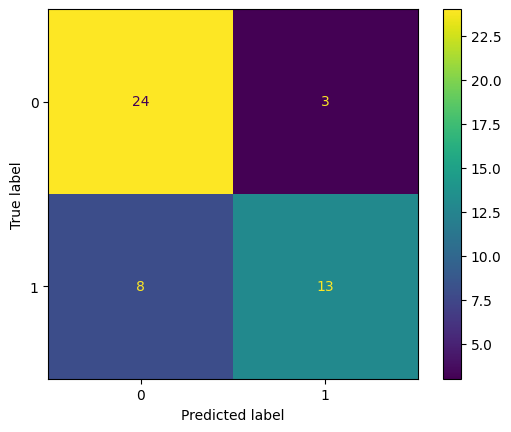

In [23]:
matrix = confusion_matrix(y_test,y_baseline)
matrix_display = ConfusionMatrixDisplay(matrix)
print("Confusion Matrix:")
matrix_display.plot()
print(matrix)

#### Confusion matrix for neural network

Confusion Matrix:
[[24  3]
 [ 5 16]]


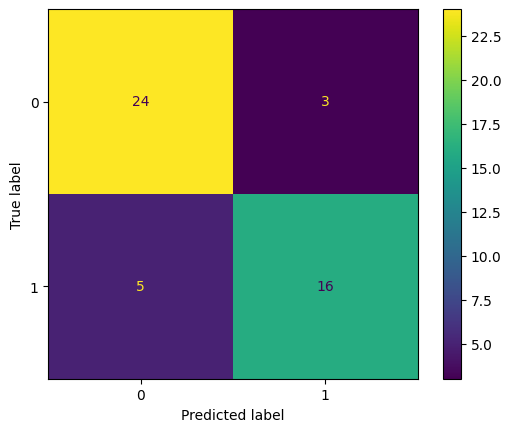

In [24]:
matrix = confusion_matrix(all_labels,all_predictions)
matrix_display = ConfusionMatrixDisplay(matrix)
print("Confusion Matrix:")
matrix_display.plot()
print(matrix)

#### Comparison of both

#### The baseline Decision tree confusion matrix shows a higher number of false negatives, meaning some patients with heart disease are incorrectly predicted as healthy. This is very concerning in a medical setting, as a sick person will miss the treatment because of this. In contrast, the Neural Networks reduce false negatives and is more effective at identifying diseased patients.

# ROC Curve + AUC

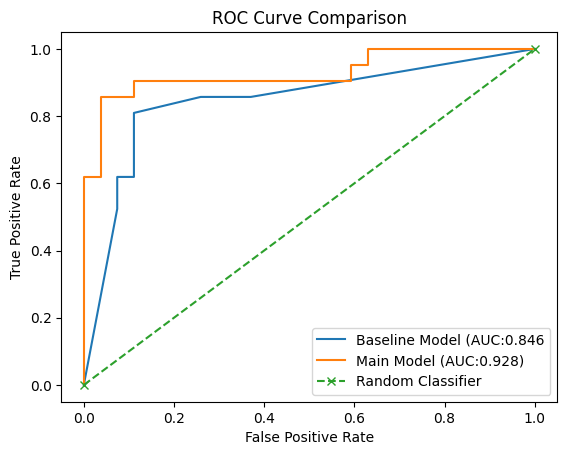

In [25]:
# Baseline calculation
y_probabilities_baseline = baseline_tree.predict_proba(x_test_scaled)[:,1]
fpr_baseline,tpr_baseline,thresholds_baseline = roc_curve(y_test,y_probabilities_baseline)
auc_baseline = auc(fpr_baseline,tpr_baseline)
plt.plot(fpr_baseline,tpr_baseline,label=f"Baseline Model (AUC:{auc_baseline:.3f}")

# Main model calculation
all_main_probs = []
all_main_labels = []

with torch.no_grad(): 
    for features, labels in test_set_loader:

        features = features.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = NN_model(features)
        probs = torch.softmax(logits,dim=1)
        all_main_probs.append(probs[:,1].cpu()) # only keep probs of class 1(which is disease)
        all_main_labels.append(labels.cpu())

y_prob_main = torch.cat(all_main_probs).numpy()
y_true_main = torch.cat(all_main_labels).numpy()

fpr_main,tpr_main,thresholds_main = roc_curve(y_true_main,y_prob_main)

auc_main = auc(fpr_main,tpr_main)

plt.plot(fpr_main,tpr_main,label=f"Main Model (AUC:{auc_main:.3f})")

plt.plot([0,1],[0,1],"x--",label="Random Classifier") # diognal line

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

plt.legend()
plt.show()

# Explainability (Which features influence more)

#### Baseline model 

In [26]:
# Extracting feature importances from the trained baseline tree
importances = baseline_tree.feature_importances_

feature_importance_df = pd.DataFrame({"Feature":x_train.columns,"Importance":importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance",ascending=False) # descending order

top_features = feature_importance_df
print(top_features)

     Feature  Importance
12      thal    0.341869
11        ca    0.186559
0        age    0.148976
1        sex    0.076311
3   trestbps    0.067441
4       chol    0.055470
9    oldpeak    0.054685
2         cp    0.030699
7    thalach    0.020408
8      exang    0.017582
5        fbs    0.000000
6    restecg    0.000000
10     slope    0.000000


#### Main model

In [27]:
first_layer_weights = NN_model.hidden_layer_1.weight.detach().cpu().numpy()
abs_weights = np.abs(first_layer_weights) # abs since we are checking influence
feature_influence = abs_weights.mean(axis=0) # this is average influence per input feature

nn_feature_df = pd.DataFrame({"Feature":x_train.columns,"Influence":feature_influence})
nn_feature_df = nn_feature_df.sort_values(by="Influence",ascending=False)


top_features = nn_feature_df
print(top_features)

     Feature  Influence
12      thal   0.210919
2         cp   0.174823
9    oldpeak   0.173676
11        ca   0.171425
7    thalach   0.156504
5        fbs   0.154513
10     slope   0.152101
4       chol   0.148180
0        age   0.144758
1        sex   0.144086
6    restecg   0.143501
8      exang   0.139192
3   trestbps   0.117513


#### Explanation

#### For the Baseline tree, feature importance values show which features were most frequently used to separate high-risk and low-risk patients, making the model easier to interpret. For the neural network, feature influence was estimated by examining the input layer weights to gain a basic understanding of important features. Since neural networks are less interpretable, this analysis was used only for intuition and not for making clinical conclusions

# Single patient Prediction

In [28]:
index = 7 # just for demonstrating purpose
x_single = x_test_scaled[index].reshape(1,-1) # feature vector for this sample
true_label = y_test.iloc[index] # true label of this patient


NN_model.eval() 
with torch.no_grad():  
    x_tensor = torch.tensor(x_single,dtype=torch.float).to(DEVICE)
    logits = NN_model(x_tensor)
    probs = torch.softmax(logits,dim=1) # probabilites 
    risk_probability = probs[0,1].item() # probability of having disease
    predicted_label = torch.argmax(probs,dim=1).item() # predicted class


print("Single Patient Prediction")
print(f"True label:{true_label}")
print(f"Predicted label:{predicted_label}")
print(f"Predicted risk probability:{risk_probability:.3f}")

if (predicted_label == 1):
    print("Interpretation: The model predicts this patient as high risk")
else:
    print("Interpretation: The model predicts this patient as low risk")

Single Patient Prediction
True label:1
Predicted label:1
Predicted risk probability:0.695
Interpretation: The model predicts this patient as high risk


# Ethics and Limitations 

#### Is this medical advice:

 This model is not a source of medical advice. It is a machine learning model designed to estimate risk based on patterns in data. The predictions are meant to support analysis and learning, not to diagnose disease or replace professional medical judgment

#### What dataset bias might exist:

The dataset might contain bias due to its limited size and demographic representation. It was collected from specific hospitals and populations, which means the model may not generalize well to patients from different regions,age groups, or ethnic backgrounds

#### Why are false negatives dangerous:

 They represent cases where a patient with disease is incorrectly classified as healthy. In a medical context, this can delay diagnosis and treatment, which can lead to more severe health outcomes.

#### What steps are needed for real world deployment:

For real world deployment, the model requires extensive clinical validation, testing on diverse and larger populations, and evaluation by medical professionals to ensure safety, reliability, and fairness.

#### Privacy concerns:

Medical data is highly sensitive, and improper handling can lead to privacy violations. Any real world deployment would require strict data protection measures, anonymization of patient records, and compliance with healthcare data privacy regulations.